In [1]:
'''
2018-11-20
following along with <https://github.com/skyfielders/astronomy-notebooks/blob/master/Solvers/Earth-Satellite-Passes.ipynb>
'''

import math

from skyfield.api import Loader, Topos, earth, JulianDate
import matplotlib.pyplot as plt
from scipy import optimize
import maidenhead as mh
import numpy as np

load = Loader('data/skyfield')

ts = load.timescale()

tau = 2.0 * np.pi

'''CONFIGURE ME!!!!'''
tle = load.tle('../tle/active.txt')
src_mh = 'EM15'
satellite = 'FOX-1B'
#satellite = 'AO-92'
window_start = (2018, 11, 24)
window_days = 5.0
min_altitude = 30.0
time_above = 15.0

# do every minute for 24 hours starting on 2018-11-19 0000Z UTC
window_minutes = 24 * 60 * window_days
time_range = ts.utc(*window_start, 0, range(int(window_minutes)))

home = Topos(*mh.toLoc(src_mh))
sat = tle[satellite]

diff = sat - home
print(diff)

def alt_f(t):
    return diff.at(t).altaz()[0].degrees

print(time_range)
print(time_range[0])
print(time_range[-1])
altitudes = alt_f(time_range)
plt.plot(time_range.tai, altitudes)
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , time_range[0].utc_iso()
        , time_range[-1].utc_iso()
    )
)

Sum of 2 vectors:
 - Topos 35deg 00' 00.0" N -98deg 00' 00.0" E
 + EarthSatellite 'RADFXSAT (FOX-1B)' number=43017 epoch=2018-12-02T11:54:47Z
<Time tt=[2458446.500800741 ... 2458451.5001062965] len=7200>
<Time tt=2458446.500800741>
<Time tt=2458451.5001062965>


Text(0.5, 1.0, 'FOX-1B elevation @ EM15\n2018-11-24T00:00:00Z to 2018-11-28T23:59:00Z')

In [2]:
# sample six points per orbit to improve performance
orbit_period_per_minute = tau / sat.model.no
orbit_period_per_day = tau / sat.model.no / 24.0 / 60.0
print(orbit_period_per_day)
orbit_period = orbit_period_per_minute / window_minutes
revolutions_in_window = 1.0 / orbit_period # approximate number of peaks
sample_points = int(math.ceil(revolutions_in_window * 6.0))
#sample_step = int(math.floor(window_minutes / sample_points))
sample_step = (time_range[-1] - time_range[0]) / sample_points
print('sample_step', sample_step)
print(revolutions_in_window, 'revolutions in window')
print(orbit_period_per_minute, 'orbital period per minute')
print(orbit_period / 6.0, 'orbit period')
print(sample_points, 'sample points (revs*6)')
#sample_time_range = ts.utc(*window_start, 0, range(0, int(math.ceil(window_minutes)), sample_step))
sample_time_range = ts.tai_jd([time_range[0].tai + (_ * sample_step) for _ in range(sample_points)])
print(sample_time_range)

sample_altitudes = alt_f(sample_time_range)
print(sample_altitudes)

0.0676028870913044
sample_step 0.011259697197290423
73.96133826721046 revolutions in window
97.34815741147834 orbital period per minute
0.0022534295697101466 orbit period
444 sample points (revs*6)
<Time tt=[2458446.500800741 ... 2458451.488846599] len=444>
[-4.96219617e+01 -5.79291138e+01 -5.33463668e+01 -4.15889430e+01
 -3.05893466e+01 -2.89621896e+01 -3.87782727e+01 -5.14181266e+01
 -5.83019973e+01 -5.25788271e+01 -3.75479685e+01 -2.34192495e+01
 -2.75851167e+01 -4.60198074e+01 -6.35650721e+01 -6.32215823e+01
 -4.27673308e+01 -1.76326570e+01 -1.64410436e+01 -4.24091748e+01
 -6.84050203e+01 -7.25787234e+01 -4.56455240e+01 -1.24979847e+01
 -7.23846612e+00 -4.12016567e+01 -7.18093709e+01 -7.72688022e+01
 -4.56944104e+01 -9.63720198e+00 -7.28920716e+00 -4.26825250e+01
 -7.26384122e+01 -7.29321661e+01 -4.28483103e+01 -1.05526453e+01
 -1.64519768e+01 -4.66387332e+01 -7.06488599e+01 -6.38150205e+01
 -3.74877915e+01 -1.44253292e+01 -2.74062194e+01 -5.25191159e+01
 -6.68627149e+01 -5.3488204

73 sample peaks
<Time tt=[2458446.557099227 ... 2458451.4212884163] len=73>


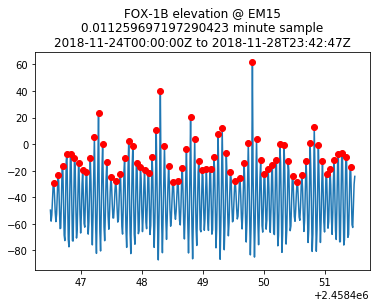

In [3]:
left_diff = np.ediff1d(sample_altitudes, to_begin=0.0)
right_diff = np.ediff1d(sample_altitudes, to_end=0.0)
maxima = (left_diff > 0.0) & (right_diff < 0.0)
print(sum(maxima), 'sample peaks')
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')
print(sample_time_range[maxima])

0.011261261261261262
<Time tt=[2458446.5528892525 ... 2458451.4161754777] len=73>


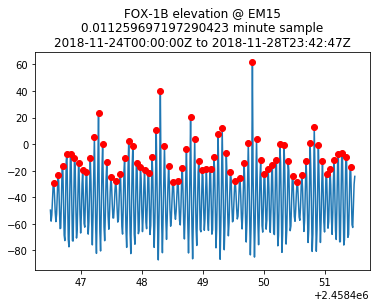

In [4]:
def alt_f_minimization_wrapper(t):
    return -alt_f(ts.tai_jd(t))

def find_highest(t, step):
    return optimize.minimize_scalar(
        alt_f_minimization_wrapper
        , bracket=[t.tai + step, t.tai - step]
        , tol=(1.0 / 24.0 / 60.0 / 60.0) / t.tai
    ).x

print((window_minutes / sample_points) / (60 * 24))
#t_highest = ts.tai_jd([find_highest(ti, (window_minutes / sample_points) / (60 * 24)) for ti in sample_time_range[maxima]])
np.random.seed(99999)
t_highest = ts.tai_jd([find_highest(ti, sample_step) for ti in sample_time_range[maxima]])
print(t_highest)
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')

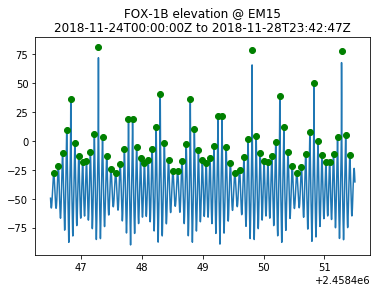

In [5]:
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(time_range.tai, altitudes)
plt.plot([_.tai for _ in t_highest], alt_f(t_highest), 'go')

In [6]:
def rising_setting_wrapper(t):
    return -alt_f_minimization_wrapper(t)

def find_rising(t, step):
    return optimize.brentq(rising_setting_wrapper, t.tai - (2 * step), t.tai)

def find_setting(t, step):
    return optimize.brentq(rising_setting_wrapper, t.tai + (2 * step), t.tai)

print(t_highest)
passes = ts.tai_jd([_.tai for _ in t_highest if alt_f(_) > min_altitude])
print(passes)
rising = ts.tai_jd([find_rising(_, (window_minutes / sample_points) / (24 * 60)) for _ in passes])
setting = ts.tai_jd([find_setting(_, (window_minutes / sample_points) / (24 * 60)) for _ in passes])

for start, peak, stop in zip(rising, passes, setting):
    print(start.utc_iso(), peak.utc_iso(), stop.utc_iso())

<Time tt=[2458446.5528892525 ... 2458451.4161754777] len=73>
<Time tt=[2458446.8330725553 ... 2458451.2809464335] len=8>
2018-11-24T07:53:12Z 2018-11-24T07:58:28Z 2018-11-24T08:04:05Z
2018-11-24T18:46:00Z 2018-11-24T18:52:38Z 2018-11-24T18:58:32Z
2018-11-25T19:08:00Z 2018-11-25T19:14:26Z 2018-11-25T19:20:11Z
2018-11-26T07:00:17Z 2018-11-26T07:05:39Z 2018-11-26T07:11:27Z
2018-11-27T07:21:56Z 2018-11-27T07:27:26Z 2018-11-27T07:33:27Z
2018-11-27T18:15:28Z 2018-11-27T18:21:39Z 2018-11-27T18:27:13Z
2018-11-28T07:43:44Z 2018-11-28T07:49:12Z 2018-11-28T07:55:10Z
2018-11-28T18:37:04Z 2018-11-28T18:43:25Z 2018-11-28T18:49:05Z
